In [27]:
from ncps.torch import CfC

# a fully connected CfC network
rnn = CfC(input_size=20, units=50)

In [28]:
from ncps.torch import CfC
from ncps.wirings import AutoNCP

wiring = AutoNCP(28, 4) # 28 neurons, 4 outputs
input_size = 20
rnn = CfC(input_size, wiring)

In [29]:
import numpy as np
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import LTC
import pytorch_lightning as pl
import torch
import torch.utils.data as data

data_x.shape:  (1, 48, 2)
data_y.shape:  (1, 48, 1)


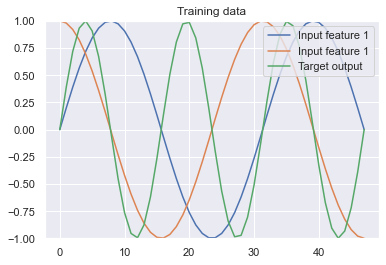

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
N = 48 # Length of the time-series
# Input feature is a sine and a cosine wave
data_x = np.stack(
    [np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis=1
)
data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
# Target output is a sine with double the frequency of the input signal
data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
print("data_x.shape: ", str(data_x.shape))
print("data_y.shape: ", str(data_y.shape))
data_x = torch.Tensor(data_x)
data_y = torch.Tensor(data_y)
dataloader = data.DataLoader(
    data.TensorDataset(data_x, data_y), batch_size=1, shuffle=True, num_workers=4
)

# Let's visualize the training data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(data_x[0, :, 0], label="Input feature 1")
plt.plot(data_x[0, :, 1], label="Input feature 1")
plt.plot(data_y[0, :, 0], label="Target output")
plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

In [31]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [32]:
wiring = AutoNCP(16, 1) #out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(2, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=400,
    gradient_clip_val=1,  # Clip gradient to stabilize training
#     gpus=0,
)

alloc!


C:\ProgramData\Anaconda3\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: mpy is an invalid version and will not be supported in a future release
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


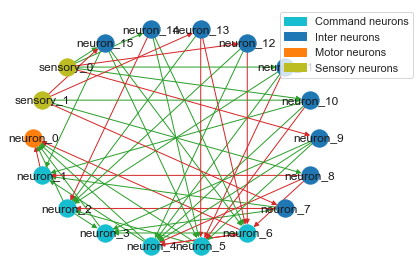

In [33]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

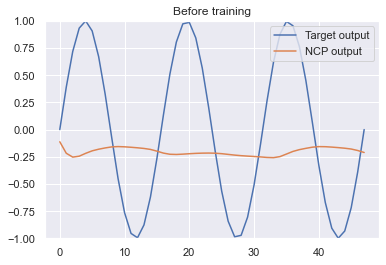

In [34]:
# Let's visualize how LTC initialy performs before the training
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [35]:
# Train the model for 400 epochs (= training steps)
trainer.fit(learn, dataloader)

C:\Users\NAOHIRO-YAMAUCHI\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\trainer\configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
Missing logger folder: log\lightning_logs

  | Name  | Type | Params
-------------------------------
0 | model | LTC  | 1.5 K 
-------------------------------
1.2 K     Trainable params
288       Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
C:\Users\NAOHIRO-YAMAUCHI\AppData\Roaming\Python\Python39\site-packages\pytorch_lightning\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


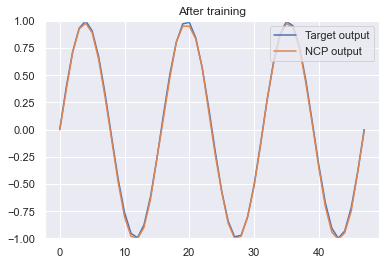

In [36]:
# How does the trained model now fit to the sinusoidal function?
sns.set()
with torch.no_grad():
    prediction = ltc_model(data_x)[0].numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="NCP output")
plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()